## Úprava tabulky Nemovitosti

In [58]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from shapely.wkt import loads

### Úprava sloupce State
1. načtení souboru
2. náhled hlavičky

In [59]:
properties = pd.read_csv('Nemovitosti.csv', encoding='UTF-8')
properties.head(1)

,Created At,Updated At,Scraped At,UID,ID,Source,Updated,Name,URL,Item Type,...,Ask Price Per Useful Area,Ask Price Per Living Area,Ask Price Fair Split,Days Since Published,Days On Display,Count Distinct Ask Price,Min Ask Price,Max Ask Price,First Ask Price,Delta Ask Price
0,2023-09-07T03:09:16.686831,2023-09-07T03:09:16.686832,2023-09-07T03:00:01,bezrealitky-206888,206888,bezrealitky,False,"Pronájem bytu 1+1 44 m², Antala Staška, Brno, ...",https://www.bezrealitky.cz/nemovitosti-byty-do...,Flat,...,329.545455,NaN,NaN,31,4,1,14500.0,14500.0,14500.0,0.0


3. zobrazení unikátních hodnot
4. nahrazení hodnot (NEW, VERY GOOD, GOOD, BAD, UNDEFINED)


In [60]:
properties['Real State'].unique()

array([ 2., nan,  1.,  3.,  4.])

In [61]:
properties['State'] = properties['Real State'].replace({
    1.0: 'NEW', 
    2.0: 'VERY GOOD', 
    3.0: 'GOOD', 
    4.0: 'BAD', 
    float('nan'): 'UNDEFINED'})

### Vytvoření sloupce City part code v tabulce nemovitostí.
1. načtení souboru s polygony městských částí

In [62]:
city_districts = gpd.read_file('City_districts_boundaries.geojson')
city_districts.head(2)

,ObjectId,kod,nazev,datum_exportu,GlobalID,SHAPE_Length,SHAPE_Area,geometry
0,1,551066,Brno-Černovice,2023-10-21 00:00:00+00:00,{6EB96659-29DB-403B-B9B2-38354CD970AE},0.120358,0.000776,"MULTIPOLYGON (((16.62823 49.19135, 16.62828 49..."
1,2,551147,Brno-Kohoutovice,2023-10-21 00:00:00+00:00,{2B5B4334-4212-400D-9D56-2F2A708CF06C},0.118019,0.000504,"MULTIPOLYGON (((16.53520 49.20312, 16.53522 49..."


2. vykreslení polygonů pro kontrolu

<Axes: >

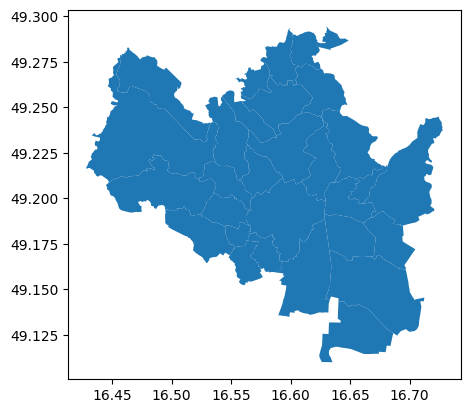

In [63]:
city_districts.plot()

3. vytvoření GeoDataFrame sestávající z lon, lat a point

In [64]:
lat = properties['Lat']
lon = properties['Lon']
df = pd.DataFrame({'lon':lon, 'lat':lat})
df['coords'] = list(zip(df['lon'],df['lat']))
df['coords'] = df['coords'].apply(Point)
points = gpd.GeoDataFrame(df, geometry='coords', crs=city_districts.crs)
points

,lon,lat,coords
0,16.618932,49.212614,POINT (16.61893 49.21261)
1,16.643782,49.213001,POINT (16.64378 49.21300)
2,16.605567,49.196370,POINT (16.60557 49.19637)
3,16.571728,49.247515,POINT (16.57173 49.24751)
4,16.595753,49.220731,POINT (16.59575 49.22073)
...,...,...,...
2211,16.524170,49.222303,POINT (16.52417 49.22230)
2212,16.617080,49.188920,POINT (16.61708 49.18892)
2213,16.647391,49.226867,POINT (16.64739 49.22687)
2214,16.604773,49.228061,POINT (16.60477 49.22806)


4. zkouška vykreslení polygonů s body pouze z jedné městské části

<Axes: >

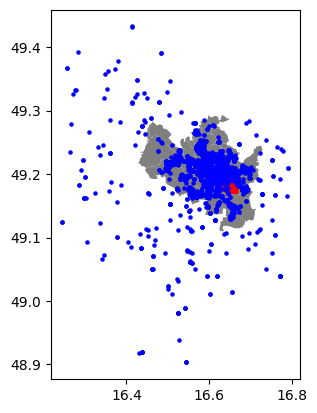

In [65]:
brno_cernovice = city_districts[city_districts.nazev == 'Brno-Černovice']

axes = city_districts.plot(facecolor="grey")
brno_cernovice.plot(ax=axes, facecolor="red")
points.plot(ax=axes, color="blue", markersize=5)

5. provedení spacial joinu = přiřazení bodů do polygonů

In [66]:
pointInPolys = gpd.tools.sjoin(points, city_districts, predicate="within", how='left')
pointInPolys

,lon,lat,coords,index_right,ObjectId,kod,nazev,datum_exportu,GlobalID,SHAPE_Length,SHAPE_Area
0,16.618932,49.212614,POINT (16.61893 49.21261),15.0,16.0,551031.0,Brno-sever,2023-10-21 00:00:00+00:00,{67B72B6A-CE04-409E-94B5-06A724600FDF},0.322636,0.001512
1,16.643782,49.213001,POINT (16.64378 49.21300),21.0,22.0,551252.0,Brno-Maloměřice a Obřany,2023-10-21 00:00:00+00:00,{82363699-BF66-4BF2-AF17-37891584A49C},0.198097,0.001147
2,16.605567,49.196370,POINT (16.60557 49.19637),13.0,14.0,550973.0,Brno-střed,2023-10-21 00:00:00+00:00,{3044A697-15EE-40CF-B775-BF09ED336ACD},0.235792,0.001806
3,16.571728,49.247515,POINT (16.57173 49.24751),12.0,13.0,551244.0,Brno-Řečkovice a Mokrá Hora,2023-10-21 00:00:00+00:00,{2E94E624-9698-4FF7-8A6F-4D1B31837DF0},0.191258,0.000935
4,16.595753,49.220731,POINT (16.59575 49.22073),5.0,6.0,551007.0,Brno-Královo Pole,2023-10-21 00:00:00+00:00,{69818F01-BA0F-483F-AF3A-80EC25E66A81},0.217828,0.001244
...,...,...,...,...,...,...,...,...,...,...,...
2211,16.524170,49.222303,POINT (16.52417 49.22230),11.0,12.0,551198.0,Brno-Bystrc,2023-10-21 00:00:00+00:00,{62D645F5-93FF-4D87-B43A-8D8B8F2BC1C7},0.455505,0.003366
2212,16.617080,49.188920,POINT (16.61708 49.18892),13.0,14.0,550973.0,Brno-střed,2023-10-21 00:00:00+00:00,{3044A697-15EE-40CF-B775-BF09ED336ACD},0.235792,0.001806
2213,16.647391,49.226867,POINT (16.64739 49.22687),21.0,22.0,551252.0,Brno-Maloměřice a Obřany,2023-10-21 00:00:00+00:00,{82363699-BF66-4BF2-AF17-37891584A49C},0.198097,0.001147
2214,16.604773,49.228061,POINT (16.60477 49.22806),5.0,6.0,551007.0,Brno-Královo Pole,2023-10-21 00:00:00+00:00,{69818F01-BA0F-483F-AF3A-80EC25E66A81},0.217828,0.001244


6. vypsání sloupců pro kontrolu hodnot

In [67]:
pointInPolys[['coords', 'nazev', 'kod']]

,coords,nazev,kod
0,POINT (16.61893 49.21261),Brno-sever,551031.0
1,POINT (16.64378 49.21300),Brno-Maloměřice a Obřany,551252.0
2,POINT (16.60557 49.19637),Brno-střed,550973.0
3,POINT (16.57173 49.24751),Brno-Řečkovice a Mokrá Hora,551244.0
4,POINT (16.59575 49.22073),Brno-Královo Pole,551007.0
...,...,...,...
2211,POINT (16.52417 49.22230),Brno-Bystrc,551198.0
2212,POINT (16.61708 49.18892),Brno-střed,550973.0
2213,POINT (16.64739 49.22687),Brno-Maloměřice a Obřany,551252.0
2214,POINT (16.60477 49.22806),Brno-Královo Pole,551007.0


7. vypsání nulových hodnot

In [68]:
null_values = pointInPolys[pointInPolys['nazev'].isnull()]
null_values

,lon,lat,coords,index_right,ObjectId,kod,nazev,datum_exportu,GlobalID,SHAPE_Length,SHAPE_Area
351,16.412793,49.311356,POINT (16.41279 49.31136),NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
360,16.751282,49.075339,POINT (16.75128 49.07534),NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
372,16.543644,48.902961,POINT (16.54364 48.90296),NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
376,16.614412,49.127890,POINT (16.61441 49.12789),NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
399,16.543644,48.902960,POINT (16.54364 48.90296),NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2193,16.557922,49.076009,POINT (16.55792 49.07601),NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2205,16.727311,49.168629,POINT (16.72731 49.16863),NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2207,16.523287,49.111179,POINT (16.52329 49.11118),NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2208,16.436284,49.083274,POINT (16.43628 49.08327),NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN


8. vykreslení bodů s nulovými hodnotami na mapě

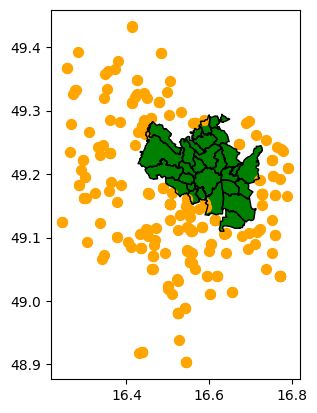

In [69]:
gdf_null = gpd.GeoDataFrame(null_values, geometry='coords')

fig, ax = plt.subplots()
city_districts.boundary.plot(ax=ax, linewidth=1, edgecolor="black")
city_districts.plot(ax=ax, color='green', markersize=50)
gdf_null.plot(ax=ax, color='orange', markersize=50) 
plt.show()

9. vyplnění prázdných hodnot

In [70]:
pointInPolys['nazev'].fillna('Brno-venkov', inplace=True)
pointInPolys['kod'] = pointInPolys['kod'].fillna(550000).astype(int)

10. přiřazení sloupců do tabulky nemovitostí, kontrola počtu (jedna městská část není zastoupena)

In [74]:
properties['coordinates'] = pointInPolys['coords']
properties['City part code'] = pointInPolys['kod']
properties['City part code'].nunique()

29

In [83]:
properties.loc[properties['Item Type'] == 'Other', ['Name', 'Item Type']]

,Name,Item Type
18,"Pronájem garáže 21 m², Francouzská, Brno, Jiho...",Other
29,"Pronájem garáže 21 m², Kytnerova, Brno, Jihomo...",Other
38,"Pronájem kanceláře 40 m², Luční, Brno, Jihomor...",Other
74,"Pronájem garáže 15 m², Kamechy, Brno, Jihomora...",Other
96,"Prodej nebytového prostoru 8 m², Halasovo námě...",Other
...,...,...
2200,Prodej kanceláře 386 m²,Other
2204,Pronájem skladového prostoru 46 m²,Other
2210,Pronájem kanceláře 477 m²,Other
2212,Pronájem kanceláře 557 m²,Other


In [97]:
properties['Item type'] = properties['Item type'].astype(str)
properties_garaz = properties.loc[properties['Name'].str.contains('garáže' case=False)]
properties.loc[properties['Name'].str.contains('kanceláře', case=False), 'Item type'] = 'Kancelář'
properties_garaz

,Created At,Updated At,Scraped At,UID,ID,Source,Updated,Name,URL,Item Type,...,Days Since Published,Days On Display,Count Distinct Ask Price,Min Ask Price,Max Ask Price,First Ask Price,Delta Ask Price,coordinates,City part code,Item type
18,2023-09-12T03:10:32.213918,2023-09-12T03:10:32.213921,2023-09-12T03:00:01,bezrealitky-402462,402462,bezrealitky,False,"Pronájem garáže 21 m², Francouzská, Brno, Jiho...",https://www.bezrealitky.cz/nemovitosti-byty-do...,Other,...,26,26,1,2000.0,2000.0,2000.0,0.0,POINT (16.61705 49.20147),551031,Garáž
29,2023-09-09T03:10:09.391255,2023-09-09T03:10:09.391257,2023-09-09T03:00:01,bezrealitky-506057,506057,bezrealitky,False,"Pronájem garáže 21 m², Kytnerova, Brno, Jihomo...",https://www.bezrealitky.cz/nemovitosti-byty-do...,Other,...,29,29,2,2700.0,3000.0,3000.0,300.0,POINT (16.57582 49.24354),551236,Garáž
74,2023-09-05T03:09:45.811492,2023-09-05T03:09:45.811494,2023-09-05T03:00:01,bezrealitky-721367,721367,bezrealitky,False,"Pronájem garáže 15 m², Kamechy, Brno, Jihomora...",https://www.bezrealitky.cz/nemovitosti-byty-do...,Other,...,33,13,1,2900.0,2900.0,2900.0,0.0,POINT (16.50277 49.21621),551198,Garáž
127,2023-09-04T03:10:00.423779,2023-09-04T03:10:00.423781,2023-09-04T03:00:01,bezrealitky-800661,800661,bezrealitky,False,"Pronájem garáže 18 m², Fanderlíkova, Brno, Jih...",https://www.bezrealitky.cz/nemovitosti-byty-do...,Other,...,34,31,1,2500.0,2500.0,2500.0,0.0,POINT (16.57556 49.21082),550990,Garáž
183,2023-09-10T03:09:35.336851,2023-09-10T03:09:35.336853,2023-09-10T03:00:01,bezrealitky-801671,801671,bezrealitky,False,"Pronájem garáže 15 m², Dusíkova, Brno, Jihomor...",https://www.bezrealitky.cz/nemovitosti-byty-do...,Other,...,28,28,1,1990.0,1990.0,1990.0,0.0,POINT (16.62496 49.23527),551031,Garáž
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1927,2023-09-09T02:33:03.6941,2023-09-09T02:33:03.694102,2023-09-09T02:30:01,sreality-4287735116,4287735116,sreality,False,Prodej garáže 16 m²,https://www.sreality.cz/detail/prodej/ostatni/...,Other,...,29,9,1,730000.0,730000.0,730000.0,0.0,POINT (16.54548 49.16100),550000,Garáž
2010,2023-09-29T02:32:15.204494,2023-09-29T02:32:15.204496,2023-09-29T02:30:01,sreality-558994764,558994764,sreality,False,Prodej garáže 19 m²,https://www.sreality.cz/detail/prodej/ostatni/...,Other,...,9,9,1,540000.0,540000.0,540000.0,0.0,POINT (16.55265 49.06224),550000,Garáž
2019,2023-09-02T02:32:53.329877,2023-09-02T02:32:53.329879,2023-09-02T02:30:01,sreality-584033612,584033612,sreality,False,Pronájem garáže 16 m²,https://www.sreality.cz/detail/pronajem/ostatn...,Other,...,36,18,1,3000.0,3000.0,3000.0,0.0,POINT (16.57209 49.22102),550990,Garáž
2145,2023-09-27T02:33:07.535369,2023-09-27T02:33:07.535371,2023-09-27T02:30:02,sreality-850629964,850629964,sreality,False,Prodej garáže 19 m²,https://www.sreality.cz/detail/prodej/ostatni/...,Other,...,11,6,1,750000.0,750000.0,750000.0,0.0,POINT (16.64649 49.23755),551252,Garáž


In [93]:
properties['Item Type'].unique()

array(['Flat', 'Other', 'House', 'Land'], dtype=object)

In [90]:
properties.loc[properties['Item Type'] == 'Other', ['Name', 'Item Type']]

,Name,Item Type
18,"Pronájem garáže 21 m², Francouzská, Brno, Jiho...",Other
29,"Pronájem garáže 21 m², Kytnerova, Brno, Jihomo...",Other
38,"Pronájem kanceláře 40 m², Luční, Brno, Jihomor...",Other
74,"Pronájem garáže 15 m², Kamechy, Brno, Jihomora...",Other
96,"Prodej nebytového prostoru 8 m², Halasovo námě...",Other
...,...,...
2200,Prodej kanceláře 386 m²,Other
2204,Pronájem skladového prostoru 46 m²,Other
2210,Pronájem kanceláře 477 m²,Other
2212,Pronájem kanceláře 557 m²,Other


Zápis upraveného souboru.

In [72]:
properties.to_csv('Nemovitosti_v4.tsv', sep='\t', index=False)